In [215]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
from sklearn import linear_model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cross_validation import cross_val_score
# from sklearn.model_selection import cross_val_score     did not work...need to update sklearn
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
import warnings
warnings.filterwarnings('ignore')

In [243]:
# Read the csvs
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Create numpy arrays for values (i.e. pixels)
trainVals = train.values[:,1:]
testVals = test.values

# Create numpy array for target labels
targets = train.values[:,0]

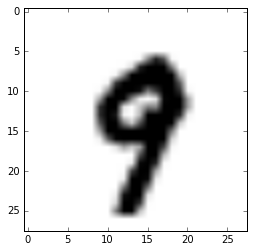

In [7]:
plt.imshow(trainVals[28,].reshape(28,28),cmap='Greys')

The following functions will

1) Find the absolute value of the difference from one pixel to the next pixel immediately following it, and do this for a whole row or column of the image. It will then sum these absolute values. I then divide the resulting number by two to get the number of bumps in a particular row or column.

2) Use the previous function on each of the rows and columns of a particular image and add them to the image. Do this for all images.

In [48]:
def sumAbsValDif(v):
    shifted_v = np.delete(v,0)
    v = np.delete(v,27)
    diff = np.subtract(shifted_v,v)
    return sum([abs(x) for x in diff])/2

def addNewBumpFeature(oldImage):
    imageMatrix = oldImage.reshape(28,28)
    oldImageList = list(deepcopy(oldImage))
    for j in range(28):
        oldImageList.append(sumAbsValDif(imageMatrix[j,]))
    for j in range(28):
        oldImageList.append(sumAbsValDif(imageMatrix[:,j]))
    imagePlusFeatures = oldImageList
    return imagePlusFeatures

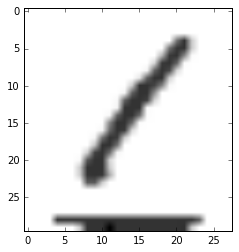

In [49]:
# Check to see if the functions are working properly...They do.
oldImage = trainVals[0,]
imagePlusFeatures = addNewBumpFeature(oldImage)
plt.imshow(np.reshape(imagePlusFeatures,newshape=(30,28)),cmap='Greys')

Add the horizontal and vertical bump features to all images.

In [50]:
newTrainVals = []
for i in range(len(trainVals)):
    oldImagei = trainVals[i,]
    newTrainVals.append(addNewBumpFeature(oldImagei))

newTrainVals = np.reshape(newTrainVals, newshape = (len(trainVals),840))

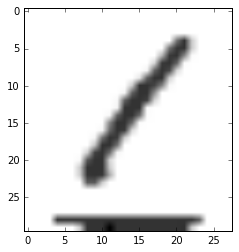

In [51]:
# Check to see if the above chunk worked properly...It did.
plt.imshow(newTrainVals[0,].reshape(30,28),cmap='Greys')

Run LDA on the new training data and perform cross validation to get estimates of the correct classification rate. It takes around a minute.

In [216]:
# Set LDA model
lda = LDA()

# get scores for 10-fold cross validation of
#   LDA model run on training data that is fitted to target labels
scores = cross_val_score(lda, newTrainVals, targets, cv=10)

In [221]:
 print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [ 0.92106515  0.91127498  0.92479772  0.92168531  0.92071429  0.91521791
  0.91283639  0.922802    0.92850334  0.92302193]


In [222]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.92


This improved the cross validation prediction rates by around 6% from the last assignment. It was at an 86% correct prediction rate, and now it is 92%. This is pretty cool because it was a simple feature to add and gave a nice improvement.

I was then curious to see whether changing all positive pixels to 1s (i.e. removing blurriness) would help the classification at all. I changed all positive pixel values to 1.

In [55]:
trainVals1s = deepcopy(trainVals)

trainVals1s[trainVals1s>0] = 1

Re-ran the addNewBumpFeature function on all images for the new 1's and 0's training data.

In [223]:
newTrainVals1s = []
for i in range(len(trainVals1s)):
    oldImagei = trainVals1s[i,]
    newTrainVals1s.append(addNewBumpFeature(oldImagei))

newTrainVals1s = np.reshape(newTrainVals1s, newshape = (len(trainVals1s),840))

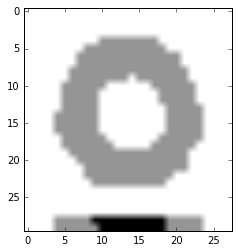

In [57]:
# Check to see if the above chunk worked properly...It did.
plt.imshow(newTrainVals1s[1,].reshape(30,28),cmap='Greys')

Run LDA on the new training data and perform cross validation to get estimates of the correct classification rate.

In [224]:
# Set LDA model
lda = LDA()

# get scores for 10-fold cross validation of
#   LDA model run on training data that is fitted to target labels
scores = cross_val_score(lda, newTrainVals1s, targets, cv=10)

In [225]:
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [ 0.91892534  0.9141294   0.92170395  0.91287789  0.9197619   0.91140748
  0.91521791  0.91470098  0.92183031  0.9099142 ]


In [226]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.92


There was no significant change in the classification rate.

I noticed a pattern in the two new 28 pixel rows of each image that will help us to define the number of regions and the number of complete circles (equivalent to the number of regions - 1). When I say circles, they don't need to be pretty circles...just a mass of 0 pixels completely surrounded by 1 pixels. At the very least, I can get good estimates of these numbers with minimal effort. I did this by using the bump data to find the max number of bumps in the vertical and horizontal directions. I multiplied these numbers for each image to get maximum cross bumps and floor divided by 4. This gives an estimate for the number of circles in an image (the number 0 has a max cross bump of 4 and therefore gets and estimate of 1 for its number of circles, the number eight will have max cross bump of 8 and therefore have an estimate of 2. Unfortunately there are many falsely identified images (3s get mapped to 2, 4s get mapped to 1). This technique will probably perform poorly because it mostly fails for the images that are weirdly shaped in some way. This technique probably won't add much predictive power for these hard to identify images.

I also found the number of unique horizontal bump numbers and the number of unique vertical bumps numbers and multiplied these numbers for each image. I thought that this was a cool way to measure the complexity of a number. I added the three numbers (maxCrossBumps, estimated number of circles, and complexity) as new features for all images.

In [83]:
def comboBumps(bumps):
    hBumps = set(bumps[0,])
    vBumps = set(bumps[1,])
    complexity = len(hBumps) * len(vBumps)
    maxHBumps = max(hBumps)
    maxVBumps = max(vBumps)
    maxCrossBumps = maxHBumps * maxVBumps
    return complexity, maxCrossBumps

def addNumCirclesComplexityFeatures(image):
    imageMatrix = image.reshape(30,28)
    imageList = list(deepcopy(image))
    bumps = imageMatrix[28:30,]
    complexity, maxCrossBumps = comboBumps(bumps)
    estNumCircles = maxCrossBumps//4
    imageList.extend([complexity, maxCrossBumps, estNumCircles])
    return imageList, complexity, maxCrossBumps, estNumCircles

Add the above features to all of the 0 and 1 images. I did it on the 0 and 1 images because the horizontal and vertical bumps will all be standardized to mean the same thing for these images. It will not matter how dark a pixel was in the training data. The bump will be the same size as a lighter bump in another image.

In [227]:
newTrainVals1sPlus = []
for i in range(len(trainVals1s)):
    oldImagei = newTrainVals1s[i,]
    imagePlusFeatures,complexity, maxCrossBumps, estNumCircles = addNumCirclesComplexityFeatures(oldImagei)
    newTrainVals1sPlus.append(imagePlusFeatures)

newTrainVals1sPlus = np.reshape(newTrainVals1sPlus, newshape = (len(trainVals1s),843))

Run LDA on the new training data and perform cross validation to get estimates of the correct classification rate.

In [228]:
# Set LDA model
lda = LDA()

# get scores for 10-fold cross validation of
#   LDA model run on training data that is fitted to target labels
scores = cross_val_score(lda, newTrainVals1sPlus, targets, cv=10)

In [229]:
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [ 0.92035188  0.91365366  0.92313184  0.91502023  0.91928571  0.91259824
  0.91569421  0.91898975  0.92397521  0.91301239]


In [230]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.92


Sadly, this offered no improvement to the classifications. I'm guessing that the LDA model was already getting everything it could out of the two rows that I was interrogating for more information. There is definitely a better way to make an estimate of the number of regions (e.g. islands) or circles. I will revisit this goal at a later time.

For now I will move onto the sliding circle window technique. I first create blocky circle in a 10 by 10 grid. Not sure how to do a better job of this, but it the best solution I could come up with at this moment.

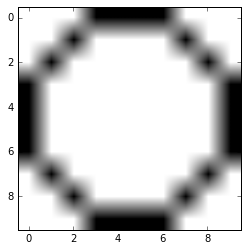

In [13]:
circle = np.array([[0,0,0,1,1,1,1,0,0,0],[0,0,1,0,0,0,0,1,0,0],[0,1,0,0,0,0,0,0,1,0],[1,0,0,0,0,0,0,0,0,1],[1,0,0,0,0,0,0,0,0,1],
                   [1,0,0,0,0,0,0,0,0,1],[1,0,0,0,0,0,0,0,0,1],[0,1,0,0,0,0,0,0,1,0],[0,0,1,0,0,0,0,1,0,0],[0,0,0,1,1,1,1,0,0,0]])

plt.imshow(circle,cmap='Greys')

In [36]:
def slidingCircleWin(image):
    imageMatrix = image.reshape(30,28)[0:28,]
    imageList = list(deepcopy(image))
    simList = []
    for i in range(18):
        for j in range(18):
            windowImage = imageMatrix[i:i+10,j:j+10]
            sim = np.sum([a*b for a,b in zip(windowImage,circle)])
            simList.append(sim)
    imageList.extend(simList)
    return imageList

The next code chuck runs the sliding window function on all 42000. This takes a long time (7 minutes on my laptop) because it is creating 324 (= 18 * 18) new features for each image.

In [231]:
newTrainVals1sPlus = []
for i in range(len(trainVals1s)):
    oldImagei = newTrainVals1s[i,]
    imagePlusFeatures = slidingCircleWin(oldImagei)
    newTrainVals1sPlus.append(imagePlusFeatures)

newTrainVals1sPlus = np.reshape(newTrainVals1sPlus, newshape = (len(trainVals1s), 1164))

Run LDA on the new training data and perform cross validation to get estimates of the correct classification rate.

In [232]:
# Set LDA model
lda = LDA()

# get scores for 10-fold cross validation of
#   LDA model run on training data that is fitted to target labels
scores = cross_val_score(lda, newTrainVals1sPlus, targets, cv=10)

In [233]:
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [ 0.91892534  0.9141294   0.92170395  0.91287789  0.9197619   0.91140748
  0.91521791  0.91470098  0.92183031  0.9099142 ]


In [234]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.92


My sliding circle approach was unsuccessful at improving the classification. I may revisit this at a later point in time. For now I will try to improve my island (region) discovery techniques. I will scratch the previous technique that focuses on the bumps. I will now do a filling technique. I will start with a 0 pixel and color it with a 2. I will then let the 2 percolate across the image and spread. it will not be allowed to spread across 1 values. I will stop this process when there is a step that nothing changes. I will then ask if there are any 0 pixels left. If there is, I will pick one and color it with a 3 and let it spread with the same rules as before (not allowing it to spread to a 1 cell). When the 3s stop spreading, I will simply count the list of unique pixel types. The 0 pixels will count anything in a 3rd island. I don't really care if there are 4 islands because there are no numbers with 4 islands as long as they are centered properly and aren't touching the outer boundaries of the grid. A proper number eight has the maximum amount of islands (3). Even a slanted eight or infinity (the most slanty of all eights) will have this property as long as the loops are closed properly. The 0s and 1s pixels are very useful for this technique because I will be able to count the number of islands very easily and the 1s offer a consistent no spread zone.

In [196]:
def fillNeighbors(x,y,newImageMatrix,zeros):
    nextActives = []
    if x-1 >= 0 and newImageMatrix[x-1,y] == 0:     # fill top
        newImageMatrix[x-1,y] = newColor
        nextActives.append([x-1,y])
        oldZeroCell = (x-1,y)
        zeros.remove(oldZeroCell)
    if x+1 <= 27 and newImageMatrix[x+1,y] == 0:    # fill bottom
        newImageMatrix[x+1,y] = newColor
        nextActives.append([x+1,y])
        oldZeroCell = (x+1,y)
        zeros.remove(oldZeroCell)
    if y-1 >= 0 and newImageMatrix[x,y-1] == 0:     # fill left
        newImageMatrix[x,y-1] = newColor
        nextActives.append([x,y-1])
        oldZeroCell =(x,y-1) 
        zeros.remove(oldZeroCell)
    if y+1 <= 27 and newImageMatrix[x,y+1] == 0:    # fill right
        newImageMatrix[x,y+1] = newColor
        nextActives.append([x,y+1])
        oldZeroCell = (x,y+1)
        zeros.remove(oldZeroCell)
    return nextActives, zeros

In [213]:
def addNumIslands(image):
    imageMatrix = image.reshape(30,28)[0:28,]
    imageList = list(deepcopy(image))
    newImageMatrix = deepcopy(imageMatrix)
    newImageMatrix[0,0] = 2
    newImageMatrix[0,27] = 2
    newImageMatrix[27,0] = 2
    newImageMatrix[27,27] = 2
    zeros = np.where(newImageMatrix == 0)
    zeros = list(zip(zeros[0],zeros[1]))
    currentActives = [[0,0], [0,27], [27,0], [27,27]]
    newColor = 2
    while len(currentActives) > 0 and newColor < 4:
        nextActives = []
        for x,y in currentActives:
            addNextActives, zeros = fillNeighbors(x,y,newImageMatrix, zeros)
            nextActives.extend(addNextActives)
        currentActives = nextActives
        if len(currentActives) == 0 and len(zeros) > 0:
            newColor += 1
            zeroCell = list(zeros[0])
            currentActives = [zeroCell]
    numIslands = newColor - 1
    imageList.append(numIslands)
    return imageList, newImageMatrix, numIslands

3


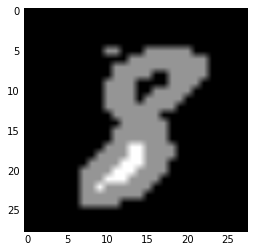

In [220]:
# Check to see if the functions work properly...They do
image = newTrainVals1s[20,]
imagePlusFeatures, newImageMatrix, numIslands = addNumIslands(image)

print("Number of islands: ", numIslands)
plt.imshow(newImageMatrix,cmap='Greys')

I tried a few values to make sure the functions are counting the number of islands properly. I also printed out one of the pictures that illustrates the different colors of the distinct islands. I am not counting the actual writing of a number as an island even though it is a distinct color. The algorithm doesn't color the last island when it gets to numColor = 4 (hence 2 black islands) because it knows that there is no need to waste time coloring it if we aren't going to go past an island number of 3 (the number 8). 

Now I can add the new feature (number of islands) to the training images. It will take somewhere around 10 minutes to run because it literally infects one island at a time and waits for it to be fully saturated before infecting the next island with a new color.

In [235]:
newTrainVals1sPlus = []
for i in range(len(trainVals1s)):
    oldImagei = newTrainVals1s[i,]
    imagePlusFeatures, newImageMatrix, numIslands = addNumIslands(oldImagei)
    newTrainVals1sPlus.append(imagePlusFeatures)

newTrainVals1sPlus = np.reshape(newTrainVals1sPlus, newshape = (len(trainVals1s), 841))

Run LDA on the new training data and perform cross validation to get estimates of the correct classification rate.

In [236]:
# Set LDA model
lda = LDA()

# get scores for 10-fold cross validation of
#   LDA model run on training data that is fitted to target labels
scores = cross_val_score(lda, newTrainVals1sPlus, targets, cv=10)

In [237]:
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [ 0.92415597  0.91817317  0.92408377  0.92144727  0.92309524  0.91855204
  0.91831388  0.92065761  0.92588179  0.91587226]


In [238]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.92


The final results are troubling and very dissapointing. I thought for sure that having a correct number of islands would help drop the error rate, but I think I'm hitting a wall with the power of LDA. I think I will need to run other models to use the full capabilities of the new features. In any case, I fought with this assignment enough and am ready to move on to other responsibilities.

I will now finish up by adding features to the test data, making an official final train on the complete training data with some of the added features, and creating a csv with the labelled test data.

In [246]:
# change positive pixels to ones in test data
testVals1s = deepcopy(testVals)
testVals1s[testVals1s>0] = 1

# add bump features to test data
newTestVals1s = []
for i in range(len(testVals1s)):
    oldImagei = testVals1s[i,]
    newTestVals1s.append(addNewBumpFeature(oldImagei))

newTestVals1s = np.reshape(newTestVals1s, newshape = (len(testVals1s),840))


In [247]:
# add region features to test data
newTestVals1sPlus = []
for i in range(len(testVals1s)):
    oldImagei = newTestVals1s[i,]
    imagePlusFeatures, newImageMatrix, numIslands = addNumIslands(oldImagei)
    newTestVals1sPlus.append(imagePlusFeatures)

newTestVals1sPlus = np.reshape(newTestVals1sPlus, newshape = (len(testVals1s), 841))

In [248]:
# train LDA to full training data with the same features as the test data
lda_fit = lda.fit(newTrainVals1sPlus, targets)

# label test data
predictions = lda_fit.predict(newTestVals1sPlus)

In [249]:
# print labeled test data with predicted labels
test.insert(0,"label",predictions)
test.to_csv("test_labeled.csv", index=False)

# create dataframe for Kaggle with imageID and predicted label
imageID = np.arange(1,28001)
columns = ['ImageID', 'Label']
test_df = pd.DataFrame(
    {'ImageID': imageID,
     'Label': predictions}, columns=columns)

# print the csv for Kaggle
test_df.to_csv("KaggleSubmissionPrice.csv", index=False)